## Cell 0: Check for GPU Availability

Ensure that TensorFlow detects one or more GPUs. Run this cell in a GPU-enabled environment (e.g., Kaggle Kernels with GPU).
.


In [1]:
# Check GPU availability
import tensorflow as tf
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Import Libraries

We import necessary libraries including scikeras for wrapping our Keras model, and also import SimpleImputer (for missing value imputation). GPU-enabled training will be used if available.

In [2]:
!pip install scikeras --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 92.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.


In [3]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Install scikeras if needed
!pip install scikeras --quiet
from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Memory Optimization Function

This function attempts to reduce memory usage by downcasting numeric columns to smaller data types (e.g., float64 -> float32, int64 -> int32.


In [4]:
# Define memory optimization function
def reduce_memory_usage(df, verbose=True):
    """Downcasts numeric columns to reduce memory usage."""
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif col_type == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB "
              f"({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)")
    return df

## Load and Optimize Data

We load our train/test data, apply the memory optimization function, and separate features/target. Adjust file names as needed for your environmen.


In [5]:
# Load and optimize data
train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

print("Before memory optimization:")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

# Separate features and target from training data
X = train.drop(columns=['id', 'rainfall'])
y = train['rainfall']

# For test data, drop the id column and save the IDs for submission
X_test = test.drop(columns=['id'])
test_ids = test['id']

print("After optimization:")
print("X shape:", X.shape)
print("X_test shape:", X_test.shape)

Before memory optimization:
Train shape: (2190, 13)
Test shape: (730, 12)
Memory usage reduced from 0.22 MB to 0.09 MB (56.7% reduction)
Memory usage reduced from 0.07 MB to 0.03 MB (54.1% reduction)
After optimization:
X shape: (2190, 11)
X_test shape: (730, 11)


## Define Preprocessing Pipelines

We create a dictionary of scalers to compare (none, standard, minmax, robust). If you prefer, you can remove or add more pipeline.


In [6]:
# Define preprocessing pipelines
preprocessors = {
    'standard': StandardScaler(),
    # 'minmax': MinMaxScaler(),
    #'robust': RobustScaler(),
    # 'raw': None
}

## Modified : Define the Expanded Keras DNN Model Function

This version of the model function accepts extra hyperparameters to allow for a deeper network. If `num_layers` is 2, the model will have two hidden layers; if 3, then three hidden layers are added..


In [7]:
# Define the expanded Keras model function
def create_dnn_model(optimizer='adam', dropout_rate=0.2, learning_rate=0.001,
                     num_layers=3, units1=64, units2=32, units3=16):
    model = Sequential()
    # First hidden layer using units1
    model.add(Dense(units1, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dropout(dropout_rate))
    
    # Second hidden layer using units2 (if at least 2 layers)
    if num_layers >= 2:
        model.add(Dense(units2, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    # Third hidden layer using units3 (if at least 3 layers)
    if num_layers >= 3:
        model.add(Dense(units3, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])
    return model

## Modified : Update KerasClassifier and Expanded Hyperparameter Grid

Note that since our pipeline step is named `'dnn'`, the parameters for the model-building function use the prefix `dnn__model__`. In addition, we add new hyperparameters: `num_layers`, `units1`, `units2`, and `units3`..


In [8]:
# Wrap the Keras model and define an expanded hyperparameter grid
dnn_wrapper = KerasClassifier(
    model=create_dnn_model,
    epochs=20,           # Default epochs; to be tuned
    batch_size=32,       # Default batch size; to be tuned
    verbose=0
)

# Expanded hyperparameter grid
param_dist = {
    'dnn__model__optimizer': ['adam', 'rmsprop'],
    'dnn__model__dropout_rate': [0.2, 0.3, 0.4],
    'dnn__model__learning_rate': [1e-3, 1e-4, 5e-4],
    'dnn__epochs': [20, 30, 50],
    'dnn__batch_size': [16, 32, 64],
    'dnn__model__num_layers': [2, 3, 4],
    'dnn__model__units1': [32, 64, 128],
    'dnn__model__units2': [32, 64, 128],
    'dnn__model__units3': [16, 32, 64]
}

## Run Hyperparameter Tuning and Generate Submissions for All Preprocessing Methods

This cell remains similar to before. For each preprocessing method (Standard, MinMax, Robust, Raw), we build a pipeline that includes an imputer, the scaler (if any), and the DNN. We run RandomizedSearchCV (using a threading backend) to tune hyperparameters. Then we manually transform the test data (to avoid the __sklearn_tags__ error) and call `predict_proba` on the DNN.

In [9]:
# Run hyperparameter tuning and generate submissions for all preprocessing methods
from joblib import parallel_backend

results = []  # List to store tuning results
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

os.makedirs("submissions", exist_ok=True)

for prep_name, scaler in preprocessors.items():
    print(f"\n--- Preprocessing: {prep_name} ---")
    
    # Build pipeline: imputer -> (scaler if provided) -> DNN
    steps = []
    steps.append(('imputer', SimpleImputer(strategy="median")))
    if scaler is not None:
        steps.append((prep_name, scaler))
    steps.append(('dnn', dnn_wrapper))
    pipeline = Pipeline(steps)
    
    with parallel_backend('threading', n_jobs=-1):
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_dist,
            n_iter=100,  # Increase iterations for a more thorough search
            scoring='roc_auc',
            cv=cv,
            verbose=0,
            random_state=42,
            n_jobs=-1
        )
        search.fit(X, y)
    
    best_score = search.best_score_
    best_params = search.best_params_
    
    print(f"Best CV ROC AUC for {prep_name}: {best_score:.4f}")
    print("Best parameters:", best_params)
    
    # Re-fit best estimator on the full training data
    best_estimator = search.best_estimator_
    best_estimator.fit(X, y)
    
    # Manually transform X_test using all steps except the final DNN step, then predict probabilities.
    X_test_transformed = best_estimator[:-1].transform(X_test)
    test_preds = best_estimator.named_steps['dnn'].predict_proba(X_test_transformed)[:, 1]
    
    # Save the submission file for this preprocessing method
    sub_filename = f"submissions/{prep_name}_dnn_submission.csv"
    sub_df = pd.DataFrame({'id': test_ids, 'rainfall': test_preds})
    sub_df.to_csv(sub_filename, index=False)
    print(f"Submission file saved: {sub_filename}\n")
    
    results.append({
        'preprocessing': prep_name,
        'best_auc': best_score,
        'best_params': best_params,
        'submission_file': sub_filename
    })


--- Preprocessing: standard ---
Best CV ROC AUC for standard: nan
Best parameters: {'dnn__model__units3': 32, 'dnn__model__units2': 128, 'dnn__model__units1': 32, 'dnn__model__optimizer': 'rmsprop', 'dnn__model__num_layers': 4, 'dnn__model__learning_rate': 0.0005, 'dnn__model__dropout_rate': 0.4, 'dnn__epochs': 30, 'dnn__batch_size': 32}
Submission file saved: submissions/standard_dnn_submission.csv



## Graphical Comparison of CV ROC AUC Scores

We create a bar plot comparing the best CV ROC AUC scores for each preprocessing method..


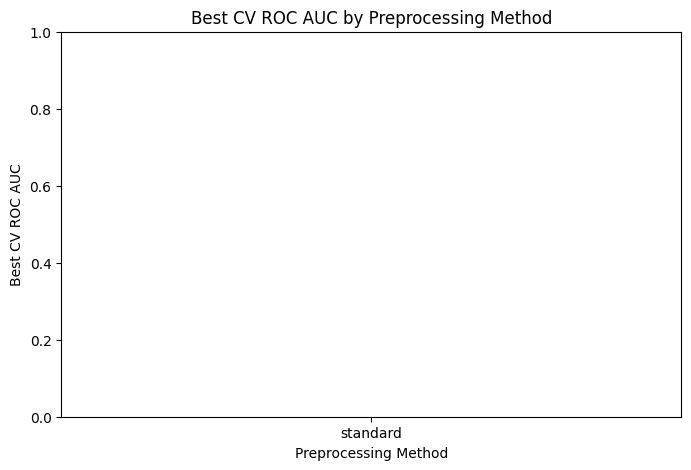

In [10]:
# Create a bar plot to compare best CV ROC AUC scores
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='best_auc', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='preprocessing', y='best_auc', data=results_df, palette='viridis')
plt.title("Best CV ROC AUC by Preprocessing Method")
plt.xlabel("Preprocessing Method")
plt.ylabel("Best CV ROC AUC")
plt.ylim(0.0, 1.0)
plt.show()

## Conclusion

- **Why Was the Score NaN?**  
  The NaN ROC AUC score may occur if certain hyperparameter combinations cause unstable training (e.g., a too-high learning rate, improper network architecture, or other settings that cause the model’s loss to become NaN or its predictions to be constant). Expanding the hyperparameter search with additional layers and units gives the model more capacity and can help stabilize training.

- **Expanded Hyperparameter Search:**  
  We increased the search space to include the number of layers (2 or 3) and varied the number of neurons in each layer. Additionally, we expanded the ranges for dropout rates and learning rates and increased the number of iterations for RandomizedSearchCV.

- **Graphical Comparison:**  
  A bar plot shows the best CV ROC AUC scores for each preprocessing method, so you can visually inspect which one performed best.

- **Final Submission:**  
  The highest scoring submission is automatically copied to **submission.csv**, while all individual submissions are saved in the "submissions" folder.

This modified and expanded search is designed to improve model performance in a competitive setting. Happy modeling and best of luck in the competition!